In [1]:
%matplotlib widget

# загрузим данные
import numpy as np
import pandas as pd

file_path = "../npz/BTCUSD_1T_close_only.npz"
data = np.load(file_path, allow_pickle=True)
df = pd.DataFrame(data['data'], columns=['timestamp', 'close'])
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['close'] = df['close'].astype(float)
df.set_index('timestamp', inplace=True)

In [2]:
train_size = 400 * 1000
dfc = df[:train_size].copy()
dfc['close'] = np.log(dfc['close']) - np.log(dfc['close'].iloc[0])

from itertools import islice

def get_positions(_windows, _diffs, _diff_mins, _diff_maxs, _grid_sizes, _i):
    positions = []
    for wi, w in islice(enumerate(_windows), 1, None):
        diff = _diffs[wi].iloc[_i]
        diff_min = _diff_mins[wi]
        diff_max = _diff_maxs[wi]
        grid_size = _grid_sizes[wi]

        # Avoid division by zero and ensure diff_max > diff_min
        if diff_max == diff_min:
            pos_fixed = 0
        else:
            pos = (grid_size - 1) * (diff - diff_min) / (diff_max - diff_min)
            pos_fixed = max(0, min(round(pos), grid_size - 1))  # Ensure position is within bounds

        positions.append(pos_fixed)
    return positions

def get_diffs(_df, _windows):
    closes = _df['close']
    mas = {}
    diffs = {}
    for wi, w in enumerate(_windows):
        mas[wi] = closes.rolling(w).mean() if w > 0 else closes
        if wi > 0:
            diffs[wi] = mas[wi] - mas[wi - 1]
    return diffs
    
def get_min_max_diffs(_diffs, _windows):
    diff_mins = [0]
    diff_maxs = [0]
    for wi, w in islice(enumerate(_windows), 1, None):
        diff_mins.append(_diffs[wi].min())
        diff_maxs.append(_diffs[wi].max())
    return diff_mins, diff_maxs

def get_transitions_map(_df, _windows, _tau, _grid_sizes, _transitions_grid_size):
    """
    creates a map of price shifts
    """
    diffs = get_diffs(_df, _windows)
    diff_mins, diff_maxs = get_min_max_diffs(diffs, _windows)

    closes = _df['close']
    transition_values = closes.shift(-_tau) - closes
    transitions_min = transition_values.min()
    transitions_max = transition_values.max()
    transitions_map = {}
    max_window = max(_windows)
    for i in range(max_window, len(_df) - _tau):
        positions = get_positions(_windows, diffs, diff_mins, diff_maxs, _grid_sizes, i)

        # Calculate transition position
        transition_value = transition_values.iloc[i]
        if transitions_max == transitions_min:
            transitions_pos_fixed = 0
        else:
            transitions_pos = (_transitions_grid_size - 1) * (transition_value - transitions_min) / (transitions_max - transitions_min)
            transitions_pos_fixed = max(0, min(round(transitions_pos), _transitions_grid_size - 1))

        # Update transitions_map
        if tuple(positions) not in transitions_map:
            transitions_map[tuple(positions)] = {}
        if transitions_pos_fixed not in transitions_map[tuple(positions)]:
            transitions_map[tuple(positions)][transitions_pos_fixed] = 1
        else:
            transitions_map[tuple(positions)][transitions_pos_fixed] += 1
    return diff_mins, diff_maxs, transitions_map, transitions_min, transitions_max

windows = [60, 120, 240, 480, 960]
grid_sizes = [43, 59, 59, 29, 29]
tau = 15
transitions_grid_size=2999

diff_mins, diff_maxs, transitions_map, transitions_min, transitions_max = \
    get_transitions_map(dfc, windows, tau, grid_sizes, transitions_grid_size)

In [3]:
# # Filter out transitions with low frequencies
# def filter_low_frequency_transitions(_transitions_map, _threshold):
#     """
#     Filters out transitions with frequencies below the given threshold.
    
#     Args:
#         transitions_map (dict): The transitions map to filter.
#         threshold (int): The minimum frequency threshold.
    
#     Returns:
#         dict: A filtered transitions map.
#     """
#     filtered_map = {}
#     for positions, counts in _transitions_map.items():
#         # Filter out transitions with counts below the threshold
#         filtered_counts = {k: v for k, v in counts.items() if v >= _threshold}
#         if filtered_counts:  # Only include positions with valid counts
#             filtered_map[positions] = filtered_counts
#     return filtered_map

# # Apply the filter with a threshold of 10
# filtered_transitions_map = filter_low_frequency_transitions(transitions_map, _threshold=90)

# #transitions_map
# filtered_transitions_map

In [4]:
def plot_transitions(_transitions_map, _skip):
    max_window = max(windows)
    start = train_size + _skip
    end = start + 10000 # len(df['close']) - 1 # start + 300 + max_window
    dfc = df[start:end].copy()
    dfc['close'] = np.log(dfc['close']) - np.log(dfc['close'].iloc[0])

    diffs = get_diffs(dfc, windows)
    averages = []
    confidences = []
    for i in range(max_window, len(dfc)):
        positions = get_positions(windows, diffs, diff_mins, diff_maxs, grid_sizes, i)
        if tuple(positions) in _transitions_map:
            probs = _transitions_map[tuple(positions)]
            average = 0
            hits = sum(probs.values())
            for k, v in probs.items():
                shift = (transitions_max - transitions_min) * k / (transitions_grid_size - 1) + transitions_min
                average += shift * v / hits
            averages.append(average)
            confidences.append(hits)
        else:
            averages.append(0)
            confidences.append(0)

    import matplotlib.pyplot as plt
    fig, ax1 = plt.subplots(figsize=(14, 6))
    ax1.plot(dfc[max_window:].index, confidences, label='confidence', color='red', alpha=0.3)
    ax1.set_ylabel('Confidence')
    ax2 = ax1.twinx() # second vertical axis with the same horizontal axis
    ax2.plot(df['close'][start:end][max_window:], label='close')
    ax2.plot(np.exp(dfc['close'][max_window:] + averages + np.log(df['close'].iloc[start])), label='average', linestyle='--')
    for wi, w in enumerate(windows):
        ax2.plot(df['close'].rolling(w).mean()[start:end][max_window:], label=f'rolling mean {w}')
    plt.legend()

    # vertical line
    vline = ax1.axvline(x=dfc.index[max_window], color='gray', linestyle='--')
    def on_mouse_move(event):
        if event.inaxes in [ax1, ax2] and event.xdata is not None:
            vline.set_xdata([event.xdata])
            fig.canvas.draw_idle()
        # remove zoom for ax1
        ax1.set_autoscale_on(False)
        ax1.set_ylim(0, max(confidences) * 1.1)
    fig.canvas.mpl_connect('motion_notify_event', on_mouse_move)

    plt.show()

skip = 150

In [5]:
skip -= 300

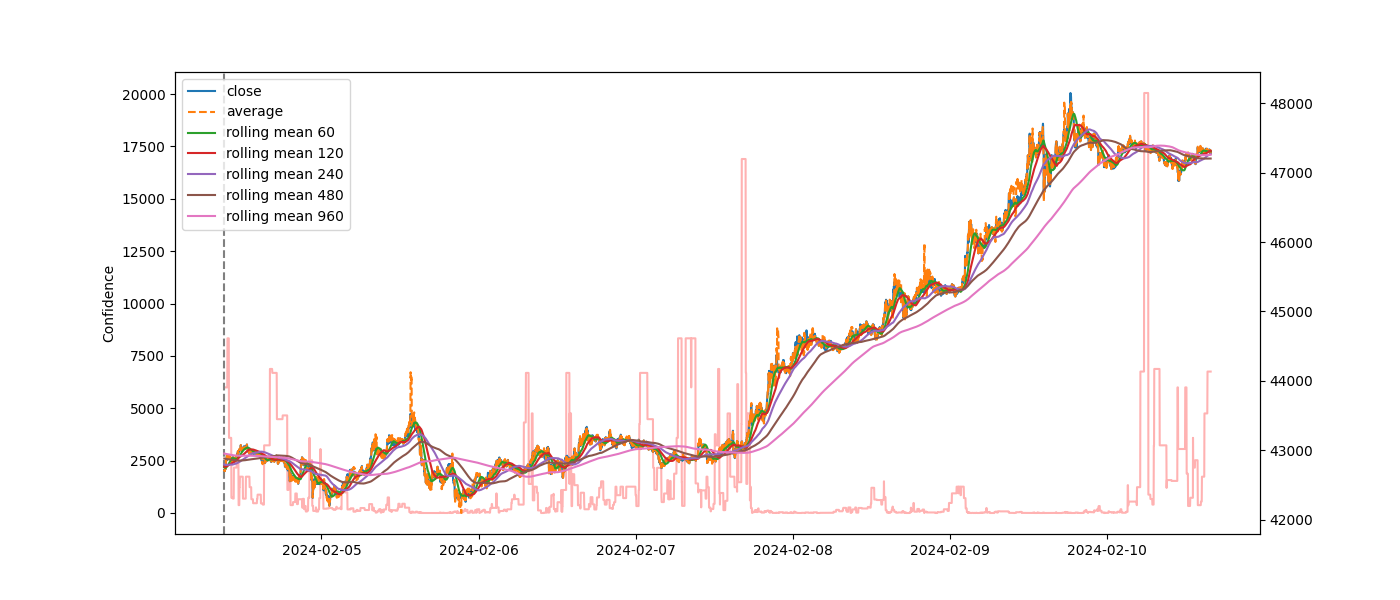

In [6]:
skip += 1500
plot_transitions(transitions_map, skip)

In [7]:
def test(_transitions_map, _windows, _grid_sizes, _diff_mins, _diff_maxs, _transitions_max, _transitions_min, _transitions_grid_size, _tau):
    max_window = max(_windows)
    start = train_size
    end = len(df['close']) - 1 # start + 300 + max_window
    dfc = df[start:end].copy()
    dfc['close'] = np.log(dfc['close']) - np.log(dfc['close'].iloc[0])
    diffs = get_diffs(dfc, _windows)
    averages = []
    confidences = []
    found = 0
    correct = 0
    wrong = 0
    for i in range(max_window, len(dfc) - _tau):
        positions = get_positions(_windows, diffs, _diff_mins, _diff_maxs, _grid_sizes, i)
        if tuple(positions) in _transitions_map:
            probs = _transitions_map[tuple(positions)]
            average = 0
            hits = sum(probs.values())
            for k, v in probs.items():
                shift = (_transitions_max - _transitions_min) * k / (_transitions_grid_size - 1) + _transitions_min
                average += shift * v / hits
            averages.append(average)
            confidences.append(hits)
            found += 1
            if dfc['close'].iloc[i + _tau] - dfc['close'].iloc[i] > 0 and average > 0:
                correct += 1
            elif dfc['close'].iloc[i + _tau] - dfc['close'].iloc[i] < 0 and average < 0:
                correct += 1
            else:
                wrong += 1
        else:
            averages.append(0)
            confidences.append(0)
    total = len(dfc) - max_window
    return found, correct, wrong, total

found, correct, wrong, total = test(transitions_map, windows, grid_sizes, diff_mins, diff_maxs, \
    transitions_max, transitions_min, transitions_grid_size, tau)
print(f'found: {found}, correct: {correct}, wrong: {wrong}, total: {total}, accuracy: {correct / found}')

found: 130857, correct: 65525, wrong: 65332, total: 167839, accuracy: 0.5007374462199194
